# Adults Census Model Training with Scikit-learn locally and Azure ML hardware

## DecisionTree Algorithm

### Azure Machine Learning Service Framework

[Analysis](#compaire)

- **Performance metrics for Local and Azure cluster compute are equal.**
- **There is no builtin Decision Tree ML Module on the designer**

## Outline

1. [Setup Development Environment](#setup)
2. [Data Preparation](#data_prep)
3. [Model Training](#train)
4. [Model Comparison](#compaire)

<a id="setup"></a>
### 1 Set up Development Environment

Azure Machine Learning Service Framework steps:
- [Create Workspace](#create_ws)
- [Create compute](#create_cm)

<a id="create_ws"></a>
##### Create Workspace

Create and Initialize Workspace
- Import base Azure ML packages
- Check the SDK version
- Connect to the workspace

In [16]:
# base packages to work with AMLS
import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Ready to use Azure ML", azureml.core.VERSION)

Ready to use Azure ML 1.19.0


In [4]:
# create a workspace

SUBSCRIPTION_ID='79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5' # provide your subscription ID
RESOURCE_GROUP_NAME  = 'unive-resource-group' # provide a resource group name
WORKSPACE_NAME  = 'unive-workspace' # provide a name for your workspace
REGION = 'westeurope' # For example: 'westeurope' or 'eastus2' or 'westus2' or 'southeastasia'.

ws = None
try:
    # Find existing workspace
    ws = Workspace(workspace_name=WORKSPACE_NAME,
                   subscription_id=SUBSCRIPTION_ID,
                   resource_group= RESOURCE_GROUP_NAME)
    print (ws.name, "found.")
except Exception as ex:
    # If workspace not found, create it
    print(ex.message)
    print("Attempting to create new workspace...")
    ws = Workspace.create(name=WORKSPACE_NAME, 
                          subscription_id=SUBSCRIPTION_ID,
                          resource_group=RESOURCE_GROUP_NAME,
                          create_resource_group=True,
                          location=REGION)
    print(ws.name, "created.")
finally:
    # Save the workspace configuration for later
    if ws != None:
        # write out the workspace details to a configuration file: .azureml/config.json
        ws.write_config(path='.azureml')
        print(ws.name, "saved.")

get_workspace error using subscription_id=79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5, resource_group_name=unive-resource-group, workspace_name=unive-workspace


Workspace not found.
Attempting to create new workspace...


Deploying AppInsights with name univeworinsights6426f6e3.
Deployed AppInsights with name univeworinsights6426f6e3. Took 4.57 seconds.
Deploying StorageAccount with name univeworstorage001930301.
Deploying KeyVault with name univeworkeyvault5d2c4045.
Deploying Workspace with name unive-workspace.
Deployed KeyVault with name univeworkeyvault5d2c4045. Took 26.6 seconds.
Deployed StorageAccount with name univeworstorage001930301. Took 28.61 seconds.
Deployed Workspace with name unive-workspace. Took 20.85 seconds.
unive-workspace created.
unive-workspace saved.


In [17]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')

unive-workspace	westeurope	unive-resource-group	westeurope


<a id="create_cm"></a>
##### Create compute

In [6]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

ws = Workspace.from_config() # This automatically looks for a directory .azureml
CPU_CLUSTER_NAME = "cpu-cluster" # Choose a name for your CPU cluster

# Verify that the cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=CPU_CLUSTER_NAME)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_D1_v2',
                                                            min_nodes = 1,
                                                            max_nodes=2, #will autoscale between zero and two nodes
                                                            idle_seconds_before_scaledown=300)
    cpu_cluster = ComputeTarget.create(ws, CPU_CLUSTER_NAME, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

# Virtual machine size: STANDARD_D1_V2 (1 Cores, 3.5 GB RAM, 50 GB Disk)
# Processing Unit: CPU - General purpose
# Virtual machine priority: Dedicated
# Minimum number of nodes: 1
# Maximum number of nodes: 2

Creating
Succeeded...........................
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


<a id="data_prep"></a>
### 2. Data Preparation
We download Adult Census Income Binary classfication dataset from github, prepreocessing, split it and send it to S3
- 2.1 [Download dataset and preprocessing](#download_ds)
- 2.2 [Upload data to Azure datastore](#upload_ds)


<a id="download_ds"></a>
##### 2.1 Download dataset and preprocessing

Dataset: https://archive.ics.uci.edu/ml/datasets/Adult

**Ref:  Exp-2_train_adult_SVC_SageMaker-v3.ipynb**

<a id="upload_ds"></a>
##### 2.2 Upload data to datastore

In [7]:
# Get the default datastore
default_ds = ws.get_default_datastore()

# Enumerate all datastores, indicating which is the default
for ds_name in ws.datastores:
    print(ds_name, "- Default =", ds_name == default_ds.name) # workspaceblobstore <- Default

# Adult Census Income Binary classfication dataset
default_ds.upload_files(files=['./data/adult.csv'], # Upload the data/adults.csv file
                       target_path='adults-data/', # Put it in a folder path in the datastore
                       overwrite=True, # Replace existing files of the same name
                       show_progress=True)

workspacefilestore - Default = False
workspaceblobstore - Default = True
Uploading an estimated of 1 files
Uploading ./data/adult.csv
Uploaded ./data/adult.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_011377cc32e946fe9c8c37f6683f9d58

<a id="train"></a>
### 3 Model Training

- [3.1 Prepare a training script](#3_1)
- [3.2 Train Model](#3_2)


<a id="3_1"></a>
#### 3.1 Prepare a training script
The below script contains training model and can run (model training) both in AMLS cluster hardware for model training name: 

- cluster: cpu-standardds1v2

Ref: /mnt/batch/tasks/shared/LS_root/mounts/clusters/cpu-standardds1v2/code/Users/877159/script


In [18]:
# Directory to write training script.
# Code Directory
import os
script_folder = os.path.join(os.getcwd(), "script")
os.makedirs(script_folder, exist_ok=True)
print(script_folder)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/cpu-standardds1v2/code/Users/877159/script


In [19]:
%%writefile $script_folder/train_adult_CART.py
import os
import time
import argparse
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from azureml.core import Run, Dataset

if __name__ =='__main__':
    
    start_time = time.time()
    
    print('extracting arguments')
    parser = argparse.ArgumentParser()
    
    # Get the experiment run context
    run = Run.get_context()

    # hyperparameters will be passed as arguments to the script.
    # example: sklearn DecisionTreeClassifier hyperparameters
    parser.add_argument('--max-leaf-nodes', type=int, default=30)
    
    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str)
    args, _ = parser.parse_known_args()

    #print(f"--max-leaf-nodes: {args.max_leaf_nodes}")
    #print(f"--model-dir: {args.model_dir}")
    
    # load dataset
    dataset_name = 'adult-dataset'
    print("Loading data from " + dataset_name)
    df = Dataset.get_by_name(workspace=run.experiment.workspace, name=dataset_name).to_pandas_dataframe()
    print(df.head())
          
    #Prepocessing
    print('building datasets')
    target = 'IncomeGroup'
    features = "age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country"
    X = df[features.split()]
    y = df[target]

    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    
    cat_ix = X.select_dtypes(include=['object', 'bool']).columns
    print(f"cat_ix: {cat_ix}")
    num_ix = X.select_dtypes(include=['int64', 'float64']).columns
    print(f"num_ix: {num_ix}")
    
    #use stratify for un balanced number of examples for each class label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)
    print(f"X_train:{X_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_train:{y_train.shape}")
    print(f"y_test: {y_test.shape}")
          
    # Model Training: Support Vector Machines
    print('training model')
    MODEL = 'CART'
    # define steps
    model = DecisionTreeClassifier(max_leaf_nodes=args.max_leaf_nodes, random_state=42)
    
    steps = [('c',OneHotEncoder(handle_unknown='ignore'),cat_ix), ('n',MinMaxScaler(),num_ix)]
    # one hot encode categorical, normalize numerical
    ct = ColumnTransformer(steps)
    # wrap the model a pipeline
    pipe  = Pipeline(steps=[('transformer',ct),('cart',model)])
    pipe.fit(X_train, y_train)
    print(f"model: {pipe}")
          
    ## Evaluate the model

    # using threshold
    threshold = 0.5 # set threshold as 0.5
    y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int) 
    print(f"y_pred: {y_pred}")
    run.log('y_pred:', y_pred)
    print(f'Misclassified examples:{(y_test != y_pred).sum()}')
    run.log('Misclassified examples:', (y_test != y_pred).sum())
    #print(pipe.predict_proba(X_test))
    #print(f"distinct y_pred: {np.unique(y_pred)}")
    #print(f"distinct y_test: {np.unique(y_test)}")
          
    # Confusion Matrix
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    print(f"confusion matrix:\n {conf_mat}")
    run.log('confusion matrix:', conf_mat)
    
    # AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    print(f"auc: {auc}")
    run.log('auc:', auc)
    
    # Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}") 
    run.log('Accuracy:', accuracy)

    # Precision
    precision = metrics.precision_score(y_test, y_pred)
    print(f"Precision: {precision}")
    run.log('Precision:', precision )

    # Recall
    recall = metrics.recall_score(y_test, y_pred)
    print(f"Recall: {recall}")
    run.log('Recall:', recall)

    # F1
    f1 = metrics.f1_score(y_test, y_pred)
    print(f"F1: {f1}")
    run.log('F1:', f1)

    
    # classification_report
    print('classification_report')
    print(metrics.classification_report(y_test, y_pred))
    run.log('classification_report', metrics.classification_report(y_test, y_pred))

    # Save model
    os.makedirs('outputs', exist_ok=True)
    joblib.dump(value = pipe, filename = f"outputs/{MODEL}.joblib")

    time_elapsed = (time.time() - start_time)
    print("Computational time:{}".format(time_elapsed))

    # Graph 3
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    run.log_image('conf_mat', plot=plt)

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/cpu-standardds1v2/code/Users/877159/script/train_adult_CART.py


<a id="3_2"></a>
#### 3.2 Train Model
- [3.2.1 Run Locally](#3_2_1)
- [3.2.2 Run model Training to the Compute Cluster](#cluster)
    - [3.2.2.1 Cluster architecture](#3_2_2_1)
    - [3.2.2.2 Initialize an Experiment](#3_2_2_2)
    - [3.2.2.3 Initialize dataset](#3_2_2_3)
    - [3.2.2.4 Create and install python environment](#3_2_2_4)
    - [3.2.2.5 Configure and submit your training run](#3_2_2_5)
    - [3.2.2.6 Register and save trained model](#3_2_2_6)
- [3.2.2 Run locally (My Desktop hardware)](#desktop)

<a id="3_2_1"></a>
##### 3.2.1 Run locally
Here we can run model Training locally (such as desktop, notebook instance, etc)

In [20]:
#! pip install watermark
%reload_ext watermark
%watermark  -d -u -h -m -v

last updated: 2020-12-15 

CPython 3.6.9
IPython 7.16.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-1100-azure
machine    : x86_64
processor  : x86_64
CPU cores  : 1
interpreter: 64bit
host name  : cpu-standardds1v2


In [21]:
import os
import time
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

if __name__ =='__main__':
    
    start_time = time.time()
    
    # Load dataset
    df = pd.read_csv("./data/adult.csv")
    print(f"df.shape: {df.shape}")
          
    #Prepocessing
    target = 'IncomeGroup'
    features = "age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country"
    X = df[features.split()]
    y = df[target]

    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    
    cat_ix = X.select_dtypes(include=['object', 'bool']).columns
    print(f"cat_ix: {cat_ix}")
    num_ix = X.select_dtypes(include=['int64', 'float64']).columns
    print(f"num_ix: {num_ix}")
    
    #use stratify for un balanced number of examples for each class label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)
    print(f"X_train:{X_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_train:{y_train.shape}")
    print(f"y_test: {y_test.shape}")
          
    # Model Training: Support Vector Machines
    print('training model')
    # define steps
    model = DecisionTreeClassifier(max_leaf_nodes=30, random_state=42)
    
    steps = [('c',OneHotEncoder(handle_unknown='ignore'),cat_ix), ('n',MinMaxScaler(),num_ix)]
    # one hot encode categorical, normalize numerical
    ct = ColumnTransformer(steps)
    # wrap the model a pipeline
    pipe  = Pipeline(steps=[('transformer',ct),('cart',model)])
    pipe.fit(X_train, y_train)
    print(f"model: {pipe}")
          
    ## Evaluate the model

    # using threshold
    threshold = 0.5 # set threshold as 0.5
    y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int) 
    print(f"y_pred: {y_pred}")
    print(f'Misclassified examples:{(y_test != y_pred).sum()}')
          
    # Confusion Matrix
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    print(f"confusion matrix:\n {conf_mat}")
    
    # AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    print(f"auc: {auc}")
    
    # Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}") 
    
    # Precision
    precision = metrics.precision_score(y_test, y_pred)
    print(f"Precision: {precision}")
    
    # Recall
    recall = metrics.recall_score(y_test, y_pred)
    print(f"Recall: {recall}")
    
    # F1
    f1 = metrics.f1_score(y_test, y_pred)
    print(f"F1: {f1}")
    
    # classification_report
    print('classification_report')
    print(metrics.classification_report(y_test, y_pred))
    
    time_elapsed = (time.time() - start_time)
    print("Computational time:{}".format(time_elapsed))

df.shape: (45222, 15)
cat_ix: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')
num_ix: Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
X_train:(31655, 14)
X_test: (13567, 14)
y_train:(31655,)
y_test: (13567,)
training model
model: Pipeline(memory=None,
         steps=[('transformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('c',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                       

<a id="cluster"></a>
##### 3.2.1 Run model Training to the Compute Cluster

To submit a training script on created cluster

<a id="3_2_1_1"></a>
###### 3.2.1.1 Cluster architecture

In [2]:
# Python implementation: CPython
# Python version       : 3.6.8

# Compiler    : GCC 7.3.0
# OS          : Linux
# Release     : 4.15.0-1098-azure
# Machine     : x86_64
# Processor   : x86_64
# CPU cores   : 1
# Architecture: 64bit

# Hostname: e6288471d32946869b90a8531cc6d254000000 

<a id="3_2_1_2"></a>
###### 3.2.1.2 Initialize an Experiment 

In [10]:
# Initialize an Experiment.
experiment_name = 'adult-DecisionTree'

from azureml.core import Experiment
experiment = Experiment(workspace=ws, name=experiment_name)
print(f"Experiment: {experiment.name}")

Experiment: adult-DecisionTree


<a id="3_2_1_3"></a>
###### 3.2.1.3 Initialize dataset 

In [11]:
# Initialize dataset
from azureml.core import Dataset

ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

#Create a tabular dataset from the path on the datastore (this may take a short while)
data_set = Dataset.Tabular.from_delimited_files(path=(ds, 'adults-data/adult.csv'))

# Display the first 20 rows as a Pandas dataframe
data_set.take(4).to_pandas_dataframe()

AzureBlob univeworstorage001930301 azureml-blobstore-0c276c1c-6e6d-4bdf-a955-8931bdfe9925


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,IncomeGroup
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K


In [15]:
# Register the dataset
dataset_name = 'adult-dataset'
data_set = data_set.register(workspace=ws, 
                           name=dataset_name,
                           description='UCI Adult "Census Income" dataset',
                           tags = {'Number of Instances':'45222',
                                   'Number of Attributes':'14'},
                           create_new_version=True)

# List the datasets registered in the workspace
for ds in ws.datasets:
    print(ds)

adult-dataset


In [18]:
dataset_name = 'adult-dataset'
df = Dataset.get_by_name(workspace=ws, name=dataset_name).to_pandas_dataframe()

print(df.shape)
print(df.columns)

(45222, 15)
Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'IncomeGroup'],
      dtype='object')


<a id="3_2_1_4"></a>
###### 3.2.1.4 Create and install python environment

In [65]:
## Create environment
# These environments are backed by cached Docker images which reduces the run preparation cost.

from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

# select sklearn Python environment
env = Environment("azml-Scikitlearn-env")
# Create a set of package dependencies (conda or pip as required)
conda_dep =  CondaDependencies.create(conda_packages=['pandas','numpy','scikit-learn','joblib','ipykernel','matplotlib','lightgbm'],
                                          pip_packages=['azureml-sdk','argparse','pyarrow','watermark'])


# Adds dependencies to PythonSection of env
env.python.conda_dependencies=conda_dep
env.register(workspace=ws)

print("AzureML-Scikit-learn-0.20.3 packages:", env.python.conda_dependencies.serialize_to_string())

AzureML-Scikit-learn-0.20.3 packages: # Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-sdk~=1.19.0
  - argparse
  - pyarrow
  - watermark
- pandas
- numpy
- scikit-learn
- joblib
- ipykernel
- matplotlib
- lightgbm
channels:
- anaconda
- conda-forge



In [66]:
env

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20200821.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": "2g"
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "azml-Scikitlearn-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "cond

In [68]:
# credit: https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments

## List Installed Environments
from azureml.core import Environment
envs = Environment.list(workspace=ws)

print(f"List of existing environments:" )
for name,env in envs.items():
    print("Name {} \t version {}".format(name,env.version))

List of existing environments:
Name azml-Scikitlearn-env 	 version 1
Name AzureML-AutoML 	 version 50
Name AzureML-PyTorch-1.0-GPU 	 version 44
Name AzureML-Scikit-learn-0.20.3 	 version 43
Name AzureML-TensorFlow-1.12-CPU 	 version 42
Name AzureML-PyTorch-1.2-GPU 	 version 44
Name AzureML-TensorFlow-2.0-GPU 	 version 42
Name AzureML-TensorFlow-2.0-CPU 	 version 41
Name AzureML-Chainer-5.1.0-GPU 	 version 44
Name AzureML-TensorFlow-1.13-CPU 	 version 43
Name AzureML-Minimal 	 version 44
Name AzureML-Chainer-5.1.0-CPU 	 version 43
Name AzureML-PyTorch-1.4-GPU 	 version 34
Name AzureML-PySpark-MmlSpark-0.15 	 version 39
Name AzureML-PyTorch-1.3-CPU 	 version 39
Name AzureML-PyTorch-1.1-GPU 	 version 44
Name AzureML-TensorFlow-1.10-GPU 	 version 44
Name AzureML-PyTorch-1.2-CPU 	 version 43
Name AzureML-TensorFlow-1.13-GPU 	 version 44
Name AzureML-TensorFlow-1.10-CPU 	 version 43
Name AzureML-PyTorch-1.3-GPU 	 version 41
Name AzureML-PyTorch-1.4-CPU 	 version 34
Name AzureML-Tutorial 	 ve

In [30]:
from azureml.core.compute import AmlCompute

cluster = None
for compute_name  in ws.compute_targets:
    cluster = ws.compute_targets[compute_name]
    if cluster and type(cluster) is AmlCompute:
        print("found compute target: " + compute_name)
        break

print(f"Cluster: {cluster}")

found compute target: cpu-cluster
Cluster: AmlCompute(workspace=Workspace.create(name='unive-workspace', subscription_id='79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5', resource_group='unive-resource-group'), name=cpu-cluster, id=/subscriptions/79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5/resourceGroups/unive-resource-group/providers/Microsoft.MachineLearningServices/workspaces/unive-workspace/computes/cpu-cluster, type=AmlCompute, provisioning_state=Succeeded, location=westeurope, tags=None)


In [32]:
ws.compute_targets['cpu-cluster']

AmlCompute(workspace=Workspace.create(name='unive-workspace', subscription_id='79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5', resource_group='unive-resource-group'), name=cpu-cluster, id=/subscriptions/79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5/resourceGroups/unive-resource-group/providers/Microsoft.MachineLearningServices/workspaces/unive-workspace/computes/cpu-cluster, type=AmlCompute, provisioning_state=Succeeded, location=westeurope, tags=None)

<a id="3_2_1_5"></a>
###### 3.2.1.5 Configure and submit your training run 

In [69]:
# credit: https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.script_run_config.scriptrunconfig?view=azure-ml-py

from azureml.core.compute import AmlCompute
from azureml.core import ScriptRunConfig, Experiment

# retrieve an environment
env = Environment.get(ws, name=env.name)

# load an experiment
experiment = Experiment(ws, experiment_name)

# retrieve a compute target
cluster = ws.compute_targets['cpu-cluster']

# configure and submit your training run
config = ScriptRunConfig(source_directory=script_folder,
                         command=['python', 'train_adult_CART.py', 
                                  '--max-leaf-nodes', '30',
                                  '--model-dir', script_folder
                                  ],
                         compute_target=cluster,
                         environment=env)

script_run = experiment.submit(config)
script_run

Experiment,Id,Type,Status,Details Page,Docs Page
adult-DecisionTree,adult-DecisionTree_1607731429_ed50fd22,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [71]:
%%time
# specify show_output to True for a verbose log
script_run.wait_for_completion(show_output=True)

RunId: adult-DecisionTree_1607731429_ed50fd22
Web View: https://ml.azure.com/experiments/adult-DecisionTree/runs/adult-DecisionTree_1607731429_ed50fd22?wsid=/subscriptions/79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5/resourcegroups/unive-resource-group/workspaces/unive-workspace

Execution Summary
RunId: adult-DecisionTree_1607731429_ed50fd22
Web View: https://ml.azure.com/experiments/adult-DecisionTree/runs/adult-DecisionTree_1607731429_ed50fd22?wsid=/subscriptions/79dab02c-2ae9-417c-ab9d-ca9bdf3a29c5/resourcegroups/unive-resource-group/workspaces/unive-workspace

CPU times: user 35.2 ms, sys: 3.55 ms, total: 38.8 ms
Wall time: 285 ms


{'runId': 'adult-DecisionTree_1607731429_ed50fd22',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-12-12T00:04:00.670474Z',
 'endTimeUtc': '2020-12-12T00:08:38.027801Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '55cbf85c-33bc-487b-be6f-8efdf05f4300',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '0e33c5b9-a072-4cbb-b09b-7ba2da209656'}, 'consumptionDetails': {'type': 'Reference'}}],
 'outputDatasets': [],
 'runDefinition': {'script': None,
  'command': 'python train_adult_CART.py --max-leaf-nodes 30 --model-dir /mnt/batch/tasks/shared/LS_root/mounts/clusters/cpu-standard-ds1-v2/code/Users/877159/script',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'cpu-cluster',
  'dataReferences': {},
  'data': {},
  'outputData':

<a id="3_2_1_6"></a>
###### 3.2.1.6 Register and save trained model

Registers the outpumodelle file in the Azure ML service workspace. Once this code completes, a Model will show up in the Azure portal.

In [73]:
# register model 
MODEL = 'CART'
model = script_run.register_model(model_name='model-adult', model_path=f'outputs/{MODEL}.joblib')
print(model.name, model.id, model.version, sep='\t')

model-adult	model-adult:1	1


<a id="desktop"></a>
##### 3.2.2 Run model Training to local desktop computer

**Ref: Exp-2_train_adult_DecisionTree_SageMaker-v3.ipynb**

<a id="compaire"></a>
### 4 Model Comparison

Note: **similar**

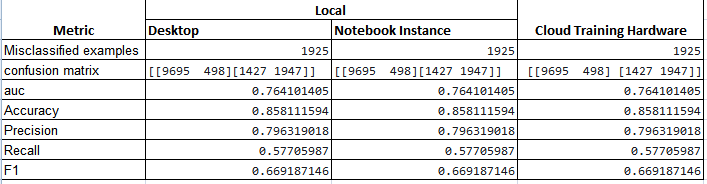

In [1]:
from IPython.display import Image

Image(filename='images/Azure/Exp-2/CART/compare.png')

#### some screenshots from Azure Model Training hardware

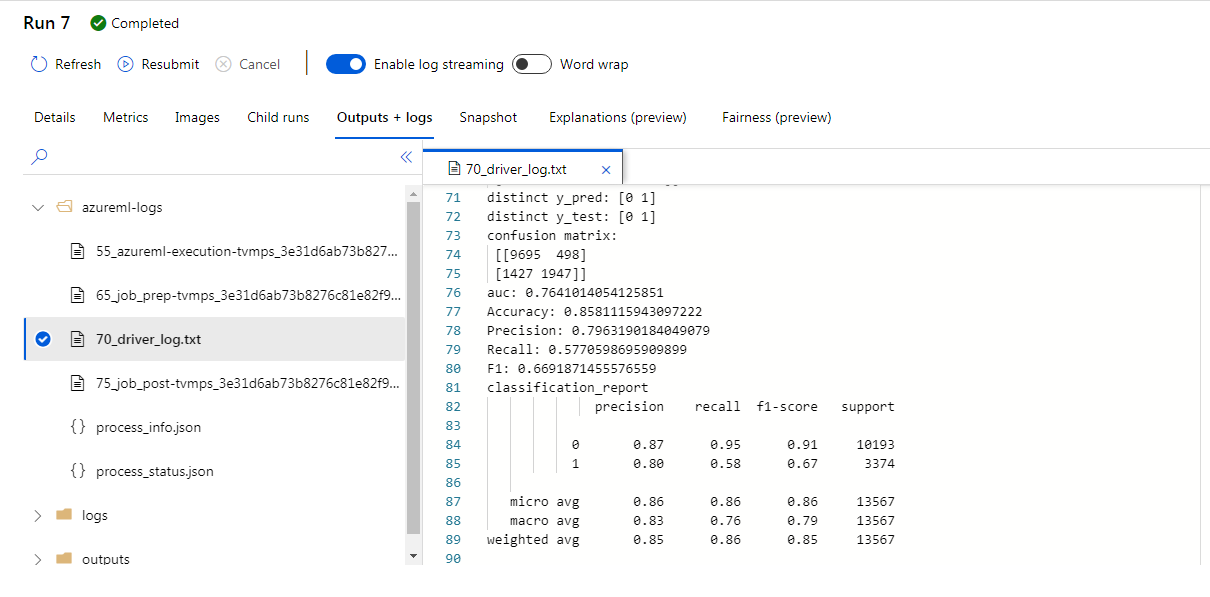

In [8]:
Image(filename='images/Azure/Exp-2/CART/driver_log.png')

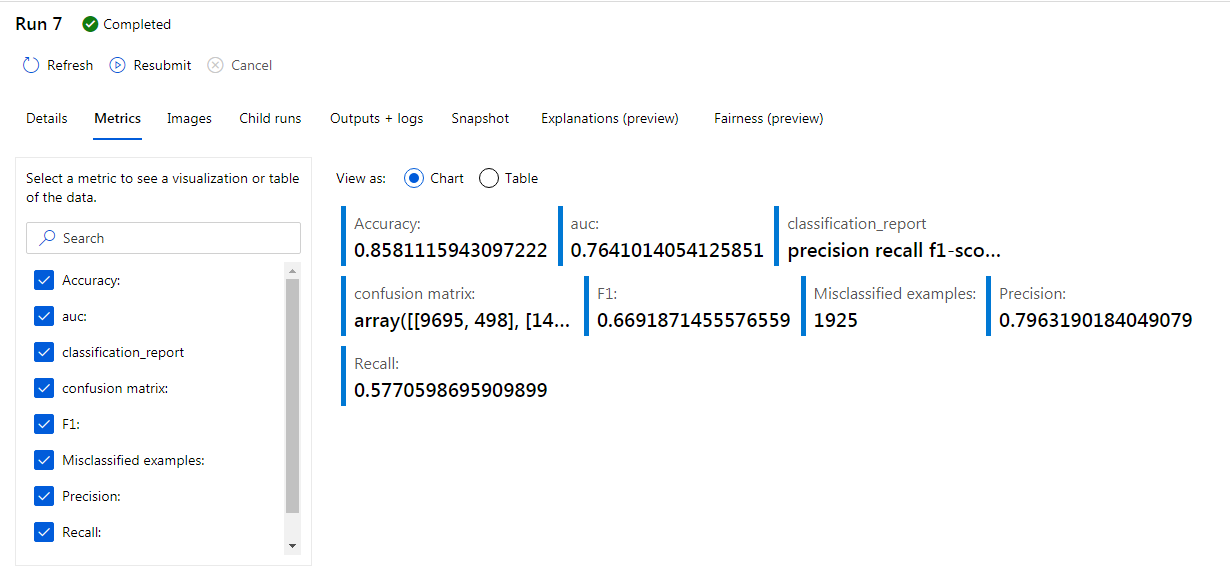

In [9]:
Image(filename='images/Azure/Exp-2/CART/metric.png')

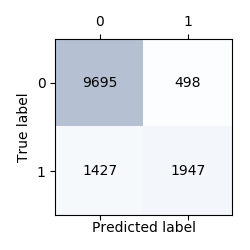

In [10]:
Image(filename='images/Azure/Exp-2/CART/conf_mat.png')

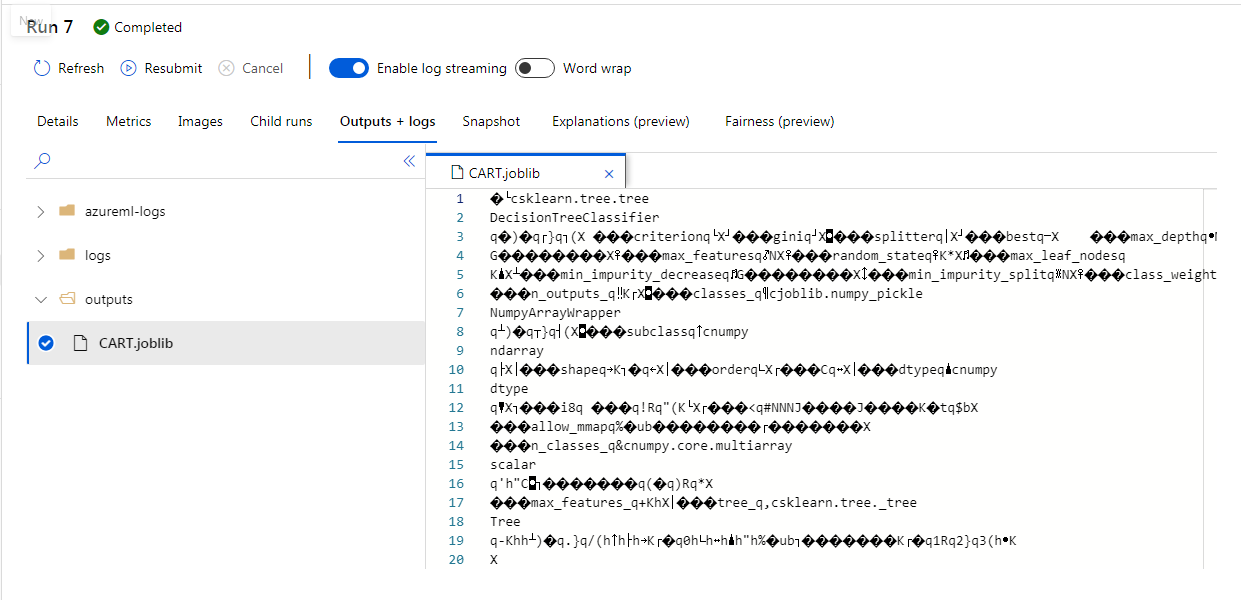

In [11]:
Image(filename='images/Azure/Exp-2/CART/domain.png')

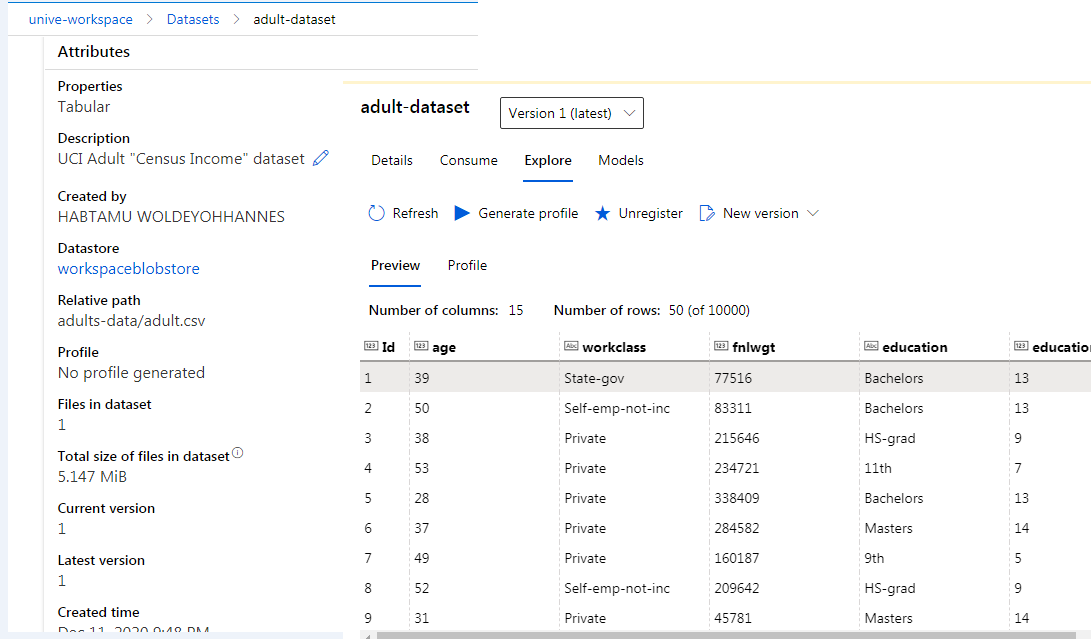

In [14]:
Image(filename='images/Azure/Exp-2/CART/dataset.png')

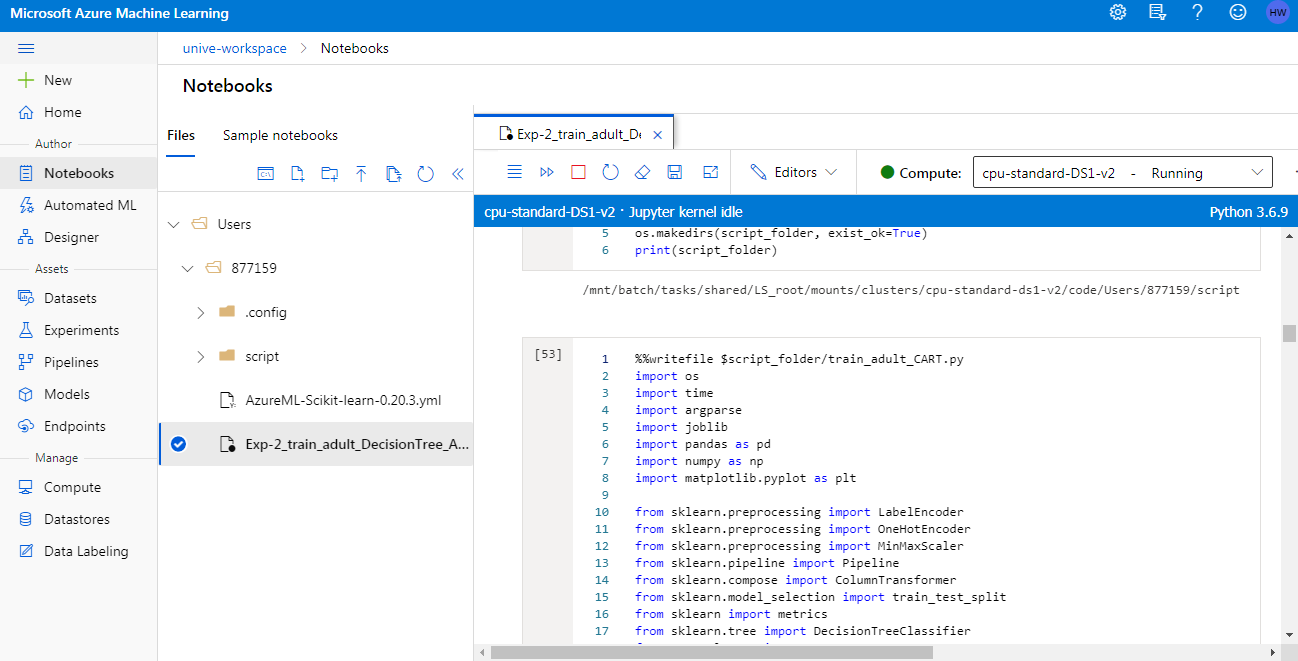

In [15]:
Image(filename='images/Azure/Exp-2/CART/Notebook.png')